In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches


# Parametros de la grilla

In [178]:
Lx, Ly = 10, 14
grid_size = (Lx, Ly)

# Carga de datos


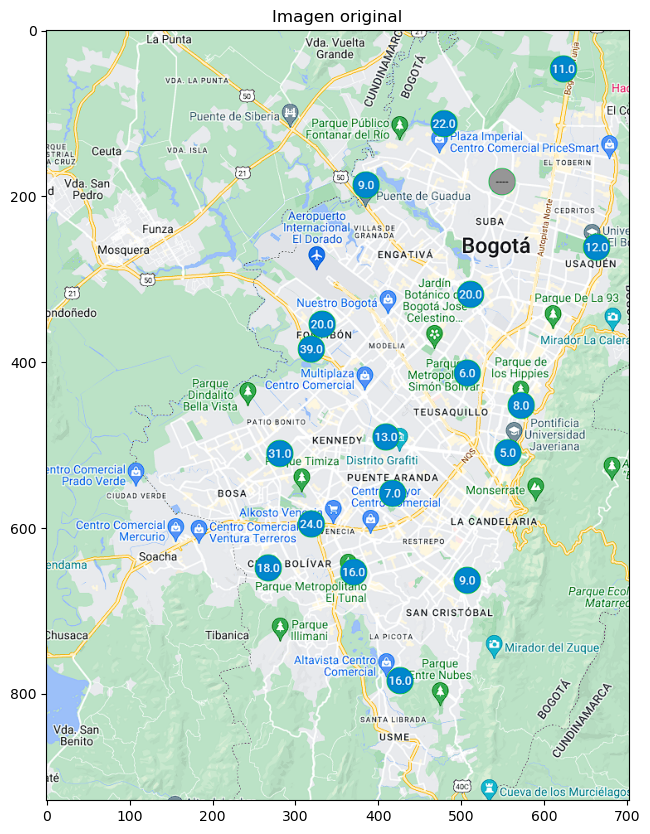

In [179]:
image_path = '../Map1.png'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(image_rgb, cmap='gray')
plt.title('Imagen original')
plt.show()

# Lectura de la imagen

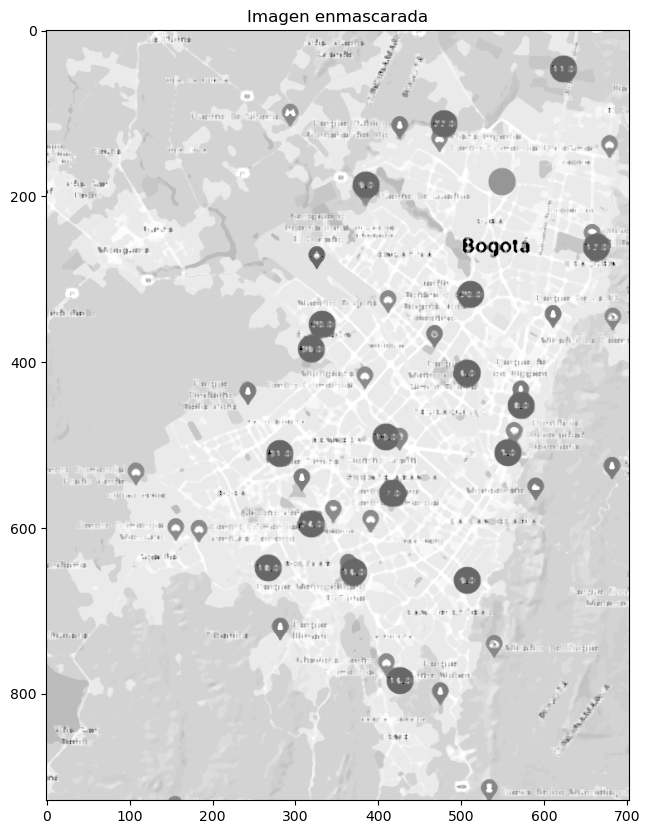

In [180]:

image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Aplicar suavizado para mejorar la detección de círculos
image_blur = cv2.medianBlur(image_gray, 5)

# Definir el rango de valores de gris oscuro
lower_gray = 100
upper_gray = 255

# Crear una máscara para los píxeles oscuros
mask = cv2.inRange(image_blur, lower_gray, upper_gray)

# Aplicar la máscara a la imagen borrosa
masked_image = cv2.bitwise_and(image_blur, image_blur, mask=mask)

# Mostrar la imagen enmascarada
plt.figure(figsize=(10, 10))
plt.imshow(masked_image, cmap='gray')
plt.title('Imagen enmascarada')
plt.show()



# Identificación de coordenadas en la grilla

Estación en la celda (1, 8)
Estación en la celda (2, 10)
Estación en la celda (3, 5)
Estación en la celda (3, 6)
Estación en la celda (3, 7)
Estación en la celda (4, 5)
Estación en la celda (4, 8)
Estación en la celda (4, 11)
Estación en la celda (5, 6)
Estación en la celda (5, 10)
Estación en la celda (5, 11)
Estación en la celda (6, 6)
Estación en la celda (6, 10)
Estación en la celda (7, 13)
Estación en la celda (8, 7)
Estación en la celda (8, 9)
Estación en la celda (8, 10)
Estación en la celda (9, 12)


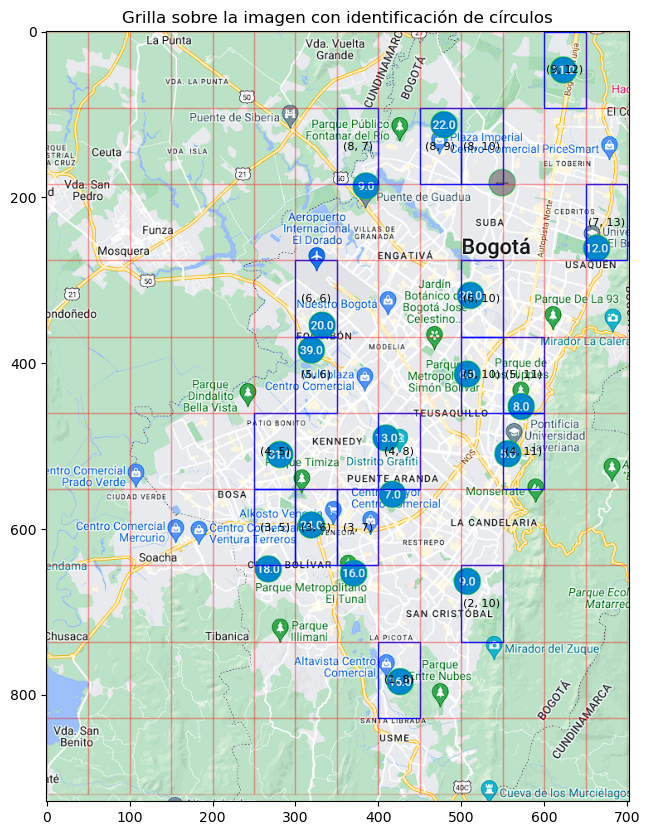

In [200]:
# Detectar círculos usando la transformada de Hough
circles = cv2.HoughCircles(masked_image, cv2.HOUGH_GRADIENT, dp=1.2, minDist=20,
                           param1=50, param2=30, minRadius=15, maxRadius=25)


# Verificar si se han detectado círculos
if circles is not None:
    # Redondear las coordenadas y el radio de los círculos
    circles = np.round(circles[0, :]).astype("int")
    # Crear una matriz para almacenar la grilla de posiciones de las estaciones
    height, width, _ = image.shape
    cell_height = height // grid_size[0]
    cell_width = width // grid_size[1]
    stations_positions = np.zeros(grid_size)

    # Crear una figura para visualizar la imagen y la grilla
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))


    # Procesar cada círculo detectado
    for (x, y, r) in circles:
        #Celda en la que se encuentra el círculo
        cell_x = x // cell_width
        cell_y = ((height - y)  // cell_height) 
        #Obs: Mirar rodeando la celda
        
        # Marcar la celda en la grilla
        stations_positions[cell_y, cell_x] = 1

    # Colorear la grilla sobre la imagen
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            if stations_positions[i, j] == 1:
                rect = patches.Rectangle((j * cell_width, (Lx - 1 - i) * cell_height), cell_width, cell_height, linewidth=1, edgecolor='b', facecolor='none', alpha=0.9)
                ax.add_patch(rect)
                # Anotar la posición en la celda
                plt.text(j * cell_width + cell_width / 2, (Lx - 1 - i) * cell_height + cell_height / 2, f'({i}, {j})', color='black', fontsize=8, ha='center', va='center', alpha=1)
                print(f'Estación en la celda ({i}, {j})')
            else:
                rect = patches.Rectangle((j * cell_width, (Lx - 1 - i) * cell_height), cell_width, cell_height, linewidth=1, edgecolor='r', facecolor='none', alpha=0.2)
                ax.add_patch(rect)

    # Mostrar la imagen con las posiciones de los círculos y la grilla coloreada
    plt.title('Grilla sobre la imagen con identificación de círculos')
    plt.show()

else:
    print("No se detectaron círculos.")

# Relacionación con las estaciones reales

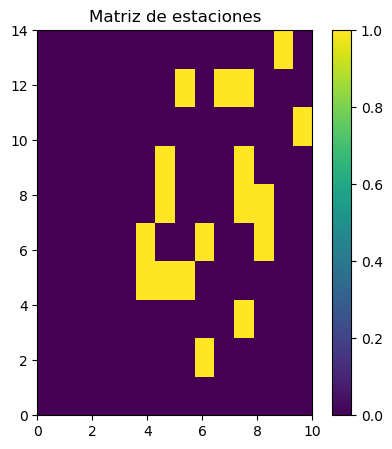

In [199]:
#Matiz de estaciones
plt.figure(figsize=(5,5))
plt.imshow(stations_positions, extent=[0, Lx, 0, Ly], origin='lower')
plt.colorbar()
plt.title('Matriz de estaciones')
plt.show()

In [212]:
#Lectura de estaciones
data_estaciones = pd.read_csv('../estaciones.txt')
data_estaciones

,Estación,VelViento,DirViento,PM10,Pm2.5
0,Guaymaral,True,True,True,True
1,Suba,True,True,True,True
2,Colina,True,True,True,True
3,Bolivia,False,False,False,True
4,Usaquén,True,True,True,True
5,Las Ferias,True,True,True,True
6,Fontibón,True,True,True,True
7,Estación Movil Fontibón,False,False,True,True
8,Centro de Alto Rendimiento,True,True,True,True
9,Móvil Séptima,True,True,True,True


In [226]:
# Inicializar listas para las coordenadas X e Y
coords_X = []
coords_Y = []


# Verificar si lo siguiente es correcto
# Recorrer `stations_positions` y asignar coordenadas a los valores distintos de cero
# Estas se recorren en i de izquierda a derecha y en j de abajo hacia arriba ya
# en el dataset se encuentran las estaciones en orden de arriba hacia abajo y 
# de izquierda a derecha
for i in reversed(range(Lx)):
    for j in reversed(range(Ly)):
        if stations_positions[i, j] != 0:
            # print(f'Estación en la celda ({i}, {j})')
            coords_X.append(i)
            coords_Y.append(j)

# Asignar las coordenadas al DataFrame
data_estaciones['X'] = coords_X
data_estaciones['Y'] = coords_Y

data_estaciones

,Estación,VelViento,DirViento,PM10,Pm2.5,X,Y
0,Guaymaral,True,True,True,True,9,12
1,Suba,True,True,True,True,8,10
2,Colina,True,True,True,True,8,9
3,Bolivia,False,False,False,True,7,13
4,Usaquén,True,True,True,True,7,7
5,Las Ferias,True,True,True,True,6,10
6,Fontibón,True,True,True,True,6,6
7,Estación Movil Fontibón,False,False,True,True,5,11
8,Centro de Alto Rendimiento,True,True,True,True,5,10
9,Móvil Séptima,True,True,True,True,5,6
